In [1]:
%load_ext autoreload

In [59]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
from scipy import stats
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [4]:
session = "JP031211"

parent_folder = "/home/adameisen/millerdata/common/datasets/sspa"
main_file = os.path.join(parent_folder, 'mat', session + '.mat')
pre_file = os.path.join(parent_folder, 'mat_pre_post', session + ' pre.mat')
post_file = os.path.join(parent_folder, 'mat_pre_post', session + ' post.mat')
uncut_file = os.path.join(parent_folder, 'mat_uncut', session + '.mat')
print("Loading data ...")
start = time.process_time()
pre_data = {}
main_data = {}
post_data = {}
uncut_data = {}
for data_dict, filename in [(pre_data, pre_file), (main_data, main_file), (post_data, post_file), (uncut_data, uncut_file)]:
    if 'pre' not in filename and 'post' not in filename:
        electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo'], verbose=False)
        data_dict['electrode_info'] = electrode_info
        data_dict['lfp'] = lfp
        data_dict['lfp_schema'] = lfp_schema
        data_dict['session_info'] = session_info
        data_dict['trial_info'] = trial_info
        data_dict['unit_info'] = unit_info
    else:
        electrode_info, lfp, lfp_schema, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'unitInfo'], verbose=False)
        data_dict['electrode_info'] = electrode_info
        data_dict['lfp'] = lfp
        data_dict['lfp_schema'] = lfp_schema
        data_dict['unit_info'] = unit_info
    print(f"loaded {filename}")

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
loaded /home/adameisen/millerdata/common/datasets/sspa/mat_pre_post/JP031211 pre.mat
loaded /home/adameisen/millerdata/common/datasets/sspa/mat/JP031211.mat
loaded /home/adameisen/millerdata/common/datasets/sspa/mat_pre_post/JP031211 post.mat
loaded /home/adameisen/millerdata/common/datasets/sspa/mat_uncut/JP031211.mat
Data loaded (took 82.00 seconds)


In [5]:
# check dt
dt = main_data['lfp_schema']['smpInterval'][0]
pre_data['lfp_schema']['smpInterval'][0], main_data['lfp_schema']['smpInterval'][0], post_data['lfp_schema']['smpInterval'][0], uncut_data['lfp_schema']['smpInterval'][0]

(0.001, 0.001, 0.001, 0.001)

In [36]:
# uncut_data['inter_trial'] = []
# sampleOn_ts = trial_info['sampleOn'][~np.isnan(trial_info['sampleOn'])]
# for i in range(len(sampleOn_ts) - 1):
#     t1 = sampleOn_ts[i]
#     t2 = sampleOn_ts[i + 1]
#     if t2 - 2 - (t1 + 3) > 2.5:
#         uncut_data['inter_trial'].append(lfp[int((t1 + 3)/dt):int((t2 - 2)/dt)])
# uncut_data['inter_trial'] = uncut_data['inter_trial']
# print(f"{len(uncut_data['inter_trial'])} inter trials")

933 inter trials


In [183]:
# reward_ts = trial_info['rewardOn'][:, -1][~np.isnan(trial_info['rewardOn'][:, -1])]

# fix_pt_ts = trial_info['fixptOn'][~np.isnan(trial_info['fixptOn'])]

# uncut_data['trial'] = []
# uncut_data['inter_trial'] = []
# trial_durations = []
# inter_trial_durations = []
# for i in range(1, len(reward_ts)):
#     t_reward = reward_ts[i]
#     bool_vec = np.logical_and(fix_pt_ts - t_reward > -6, fix_pt_ts - t_reward < 0)
#     if bool_vec.sum() == 1:
#         t_fix_pt = fix_pt_ts[bool_vec.argmax()]
#         uncut_data['trial'].append(lfp[int(t_fix_pt/dt):int(t_reward/dt)])
#         trial_durations.append(t_reward - t_fix_pt)
#         if i == 0:
#             t_start_inter_trial = 0
#         else:
#             t_end_last_trial = sampleOn_ts[((sampleOn_ts+3 - t_fix_pt) < 0).argmin() - 1] + 3
#             t_last_reward = reward_ts[(reward_ts - t_fix_pt < 0).argmin() - 1]
#             t_start_inter_trial = np.max([t_end_last_trial, t_last_reward])
#         if t_fix_pt - t_start_inter_trial > 2.5:
#             uncut_data['inter_trial'].append(lfp[int(t_start_inter_trial/dt):int(t_fix_pt/dt)])
#             inter_trial_durations.append(t_fix_pt - t_start_inter_trial)
# print(f"{len(uncut_data['trial'])} trials")
# print(f"{len(uncut_data['inter_trial'])} inter trials")

1517 trials
1446 inter trials


In [218]:
t_start_inter_trial = 0
uncut_data['trial'] = []
uncut_data['inter_trial'] = []
prev_reward = []
trial_durations = []
inter_trial_durations = []
for i in range(1, len(trial_info['outcome'])):
    outcome = trial_info['outcome'][i]
    prev_outcome = trial_info['outcome'][i - 1]
    if outcome == 'correct' or outcome == 'choiceErr':
        t_trial_start = trial_info['sampleOn'][i] - 2
        if outcome == 'correct':
            t_trial_end = trial_info['rewardOn'][i, -1]
        else: # outcome == 'choiceErr'
            t_trial_end = trial_info['responseTime'][i] + 0.1
        
        if t_trial_end - t_trial_start > 2.5:
            uncut_data['trial'].append(lfp[int(t_trial_start/dt):int(t_trial_end/dt)])
            trial_durations.append(t_trial_end - t_trial_start)
    
        if prev_outcome == 'correct' or prev_outcome == 'choiceErr':
            if prev_outcome == 'correct':
                t_prev_trial_end = trial_info['rewardOn'][i - 1, -1]
            else: # outcome == 'choiceErr'
                t_prev_trial_end = trial_info['responseTime'][i - 1] + 0.1
            
            if t_trial_start - t_prev_trial_end > 2.5:
                uncut_data['inter_trial'].append(lfp[int(t_prev_trial_end/dt):int(t_trial_start/dt)])
                inter_trial_durations.append(t_trial_start - t_prev_trial_end)
                prev_reward.append(True if prev_outcome == 'correct' else False)

(array([266., 898.,   3.,   0.,   0.,   0.,   1., 463., 120.,  34.]),
 array([4.0178  , 4.190535, 4.36327 , 4.536005, 4.70874 , 4.881475,
        5.05421 , 5.226945, 5.39968 , 5.572415, 5.74515 ]),
 <BarContainer object of 10 artists>)

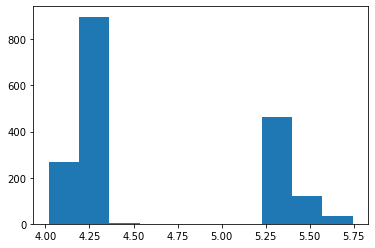

In [219]:
plt.hist(trial_durations)

(array([  8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 246.]),
 array([2.503225, 2.807005, 3.110785, 3.414565, 3.718345, 4.022125,
        4.325905, 4.629685, 4.933465, 5.237245, 5.541025]),
 <BarContainer object of 10 artists>)

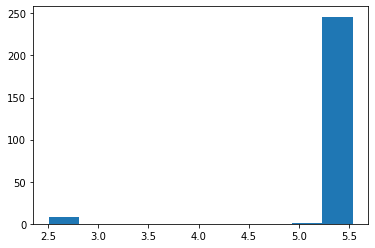

In [220]:
plt.hist(inter_trial_durations)

## VAR

In [222]:
data_path = "../../__data__/VAR/sspa"
os.makedirs(data_path, exist_ok=True)

N = main_data['lfp'].shape[1] # number of electrodes
# trial_nums = np.arange(main_data['lfp'].shape[2]) # all trials
# trial_nums = np.arange(0, main_data['lfp'].shape[2], 10) # sample trials
trial_nums = np.arange(len(uncut_data['trial'])) # all trials
inter_trial_nums = np.arange(len(uncut_data['inter_trial'])) # all inter-trials

PCA_dim = -1

results = {}
for window in [2.5]:
# for window in [0.15, 0.25, 0.5, 1, 2.5, 5]:
    stride = 0.2
    
    areas = np.unique(main_data['electrode_info']['area'])
    unit_indices = np.arange(N)[pd.Series(main_data['electrode_info']['area']).isin(areas)]

    # PRE DATA
    print("Analyzing pre data ...")
    results['pre'] = {}
    data = pre_data['lfp'][:, unit_indices]
    data = data[np.isnan(data).sum(axis=1) == 0]
    results['pre']['data'] = compute_eigs(data, dt, window, stride, return_sigma_norms=True, return_A=True, PCA_dim=PCA_dim, verbose=True)
    
    # MAIN DATA
    print("Analyzing main data ...")
    results['main'] = {'data': [], 'trial_nums': trial_nums} # make a list, one for each trial
    for trial_num in tqdm(trial_nums):
#         data = main_data['lfp'][:, unit_indices, trial_num]
        data = uncut_data['trial'][trial_num][:, unit_indices]
        results['main']['data'].append(compute_eigs(data, dt, window, stride, return_sigma_norms=True, return_A=True, PCA_dim=PCA_dim))
    
    # POST DATA
    print("Analyzing post data ...")
    results['post'] = {}
    data = post_data['lfp'][:, unit_indices]
    data = data[np.isnan(data).sum(axis=1) == 0]
    results['post']['data'] = compute_eigs(data, dt, window, stride, return_sigma_norms=True, return_A=True, PCA_dim=PCA_dim, verbose=True)
    
    # INTER-TRIAL DATA
    print("Analyzing uncut data ...")
    results['inter_trial'] = {'data': [], 'trial_nums': inter_trial_nums} # make a list, one for each trial
    for inter_trial_num in tqdm(inter_trial_nums):
        data = uncut_data['inter_trial'][inter_trial_num][:, unit_indices]
        results['inter_trial']['data'].append(compute_eigs(data, dt, window, stride, return_sigma_norms=True, return_A=True, PCA_dim=PCA_dim))
    
    results['params'] = {}
    results['params']['PCA_dim'] = PCA_dim
    results['params']['window'] = window
    results['params']['stride'] = stride
    results['params']['pre_file'] = pre_file
    results['params']['main_file'] = main_file
    results['params']['post_file'] = post_file
    
    save(results, os.path.join(data_path, f"results_all_{session}_window_{window}_stride_{stride}_v3"))

Analyzing pre data ...


  0%|          | 0/1137 [00:00<?, ?it/s]

Analyzing main data ...


  0%|          | 0/1785 [00:00<?, ?it/s]

Analyzing post data ...


  0%|          | 0/1817 [00:00<?, ?it/s]

Analyzing uncut data ...


  0%|          | 0/255 [00:00<?, ?it/s]

In [223]:
pre_CIs = results['pre']['data']['eigs']
main_CIs = []
for ret in results['main']['data']:
    main_CIs.extend(ret['eigs'])
main_CIs = np.array(main_CIs)
post_CIs = results['post']['data']['eigs']
inter_trial_CIs = []
for ret in results['inter_trial']['data']:
    inter_trial_CIs.extend(ret['eigs'])
inter_trial_CIs = np.array(inter_trial_CIs)

# pre_CIs = results['pre']['data']['eigs'].mean(axis=1)
# main_CIs = np.array([ret['eigs'] for ret in results['main']['data']]).mean(axis=2)
# post_CIs = results['post']['data']['eigs'].mean(axis=1)

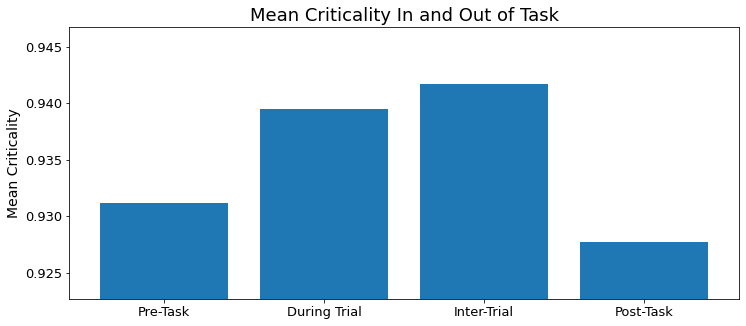

In [224]:
plt.figure(figsize=(12, 5))
bar_heights = [pre_CIs.mean(), main_CIs.mean(), inter_trial_CIs.mean(), post_CIs.mean()]
error = [pre_CIs.std()/pre_CIs.size, main_CIs.std()/main_CIs.size, inter_trial_CIs.std()/inter_trial_CIs.size, post_CIs.std()/post_CIs.size]
plt.bar(np.arange(4), bar_heights, yerr=error)
plt.xticks(np.arange(4), ['Pre-Task', 'During Trial', 'Inter-Trial', 'Post-Task'], fontsize=14)
plt.ylim([min(bar_heights) - 0.005, max(bar_heights) + 0.005])
plt.ylabel("Mean Criticality", fontsize=14)
plt.title("Mean Criticality In and Out of Task", fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.show()

In [225]:
# t-test
n1 = inter_trial_CIs.size
n2 = main_CIs.size
mean_1 = inter_trial_CIs.mean()
mean_2 = main_CIs.mean()
var_1 = inter_trial_CIs.std()**2
var_2 = main_CIs.std()**2
s_squared = (n1 - 1)/(n1 + n2 - 2)*var_1 + (n2 - 1)/(n1 + n2 - 2)*var_2
t_stat = (mean_1 - mean_2)/(np.sqrt(s_squared)*np.sqrt((1/n1) + (1/n2)))
p = 2*stats.t.sf(t_stat, df=n1 + n2 - 2)
print(p)

1.543084318344069e-68


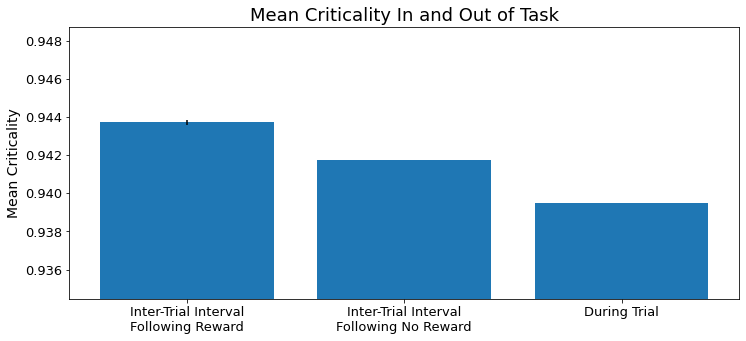

In [251]:
plt.figure(figsize=(12, 5))
ITCI_follow_reward = []
ITCI_follow_no_reward = []
for i in range(len(prev_reward)):
    if prev_reward[i]:
        ITCI_follow_reward.extend(results['inter_trial']['data'][i]['eigs'])
    else:
        ITCI_follow_no_reward.extend(results['inter_trial']['data'][i]['eigs'])
ITCI_follow_reward = np.array(ITCI_follow_reward)
ITCI_follow_no_reward = np.array(ITCI_follow_no_reward)
bar_heights = [ITCI_follow_reward.mean(), ITCI_follow_no_reward.mean(), main_CIs.mean()]
error = [ITCI_follow_reward.std()/ITCI_follow_reward.size, ITCI_follow_no_reward.std()/ITCI_follow_no_reward.size, main_CIs.std()/main_CIs.size]
plt.bar(np.arange(3), bar_heights, yerr=error)
plt.xticks(np.arange(3), ['Inter-Trial Interval\nFollowing Reward', 'Inter-Trial Interval\nFollowing No Reward', 'During Trial'], fontsize=14)
plt.ylim([min(bar_heights) - 0.005, max(bar_heights) + 0.005])
plt.ylabel("Mean Criticality", fontsize=14)
plt.title("Mean Criticality In and Out of Task", fontsize=18)
ax = plt.gca()
ax.tick_params(labelsize=13)
plt.show()

In [53]:
# index = 8
# trial_num = results['main']['trial_nums'][index]
# start_times = np.arange(results['pre']['data']['eigs'].shape[0])*results['params']['stride']/60
# plt.plot(start_times, results['pre']['data']['eigs'].mean(axis=1), label='pre task')
# start_times = np.arange(results['main']['data'][index]['eigs'].shape[0])*results['params']['stride']/60
# plt.plot(start_times, results['main']['data'][index]['eigs'].mean(axis=1), label=f'during task (trial {trial_num})')
# start_times = np.arange(results['post']['data']['eigs'].shape[0])*results['params']['stride']/60
# plt.plot(start_times, results['post']['data']['eigs'].mean(axis=1), label='post_task')
# plt.legend()
# plt.xlabel("Time (min)")
# plt.show()